In [1]:
# pls install PySinga before running the code
import numpy as np
import os
import gzip
import argparse
import cPickle
from singa import initializer
from singa import utils
from singa import optimizer
from singa import device
from singa import tensor


import utils
import Image
import matplotlib.pyplot as plt
%matplotlib inline

from singa.proto import core_pb2

import urllib
# pls download the file 
def load_train_data():
    # download the data for the first time running
    print 'downloading data'
    urllib.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz', 'data.bin')
    print 'finished data downloading'
    f = gzip.open('data.bin', 'rb')
    train_set, valid_set, test_set = cPickle.load(f)
    traindata = train_set[0].astype(np.float32)
    validdata = valid_set[0].astype(np.float32)
    print traindata.shape, validdata.shape
    return traindata, validdata



Start intialization............
Loading data ..................
downloading data
finished data downloading
(50000, 784) (10000, 784)
num_train_batch = 500 
Epoch 0
training errorsum = 13.922807
Epoch 1
training errorsum = 8.721448
Epoch 2
training errorsum = 7.938262
Epoch 3
training errorsum = 7.585506
Epoch 4
training errorsum = 7.358841
Epoch 5
training errorsum = 7.194983
Epoch 6
training errorsum = 7.065387
Epoch 7
training errorsum = 6.971709
Epoch 8
training errorsum = 6.883042
Epoch 9
training errorsum = 6.815583


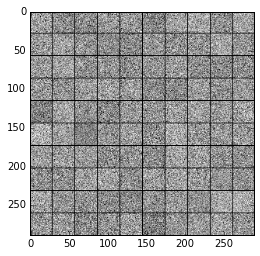

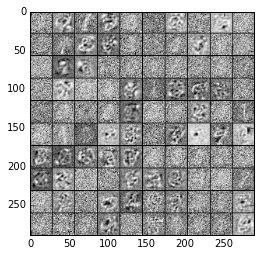

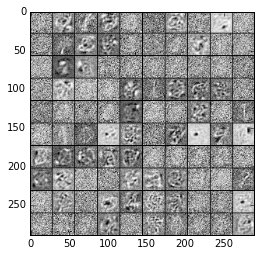

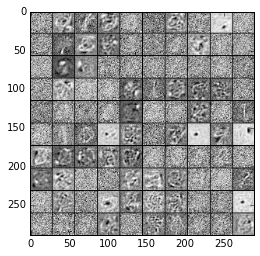

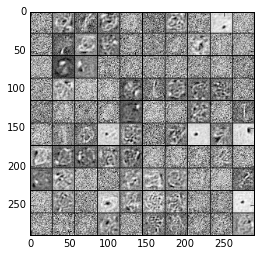

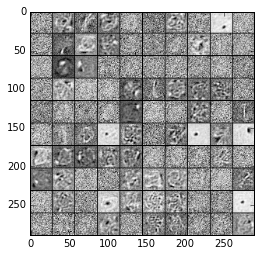

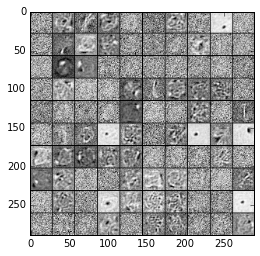

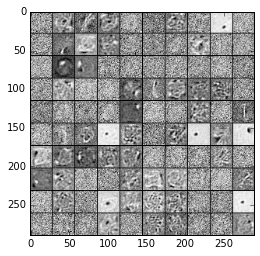

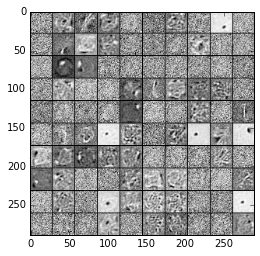

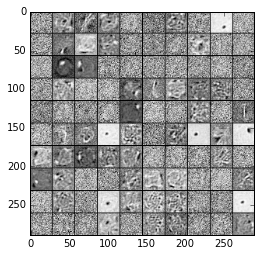

In [2]:
def train(use_gpu, num_epoch=10, batch_size=100):
    print 'Start intialization............'
    lr = 0.1   # Learning rate
    weight_decay  = 0.0002
    hdim = 1000
    vdim = 784
    opt = optimizer.SGD(momentum=0.8, weight_decay=weight_decay) 
    
    tweight = tensor.Tensor((vdim, hdim))
    tweight.gaussian(0.0, 0.1)
    tvbias = tensor.from_numpy(np.zeros(vdim, dtype = np.float32))
    thbias = tensor.from_numpy(np.zeros(hdim, dtype = np.float32))
    print 'Loading data ..................'
    train_x,_ = load_train_data()

    if use_gpu:
        dev = device.create_cuda_gpu()
    else:
        dev = device.get_default_device()

    for t in [tweight, tvbias, thbias]:
        t.to_device(dev)

    num_train_batch = train_x.shape[0] / batch_size
    
    print "num_train_batch = %d " % (num_train_batch)
    for epoch in range(num_epoch):
        tweight.to_host()
        wnp = tensor.to_numpy(tweight)
        image = Image.fromarray(utils.tile_raster_images( #Image.fromarray
                X = wnp.T,
                img_shape=(28, 28),
                tile_shape=(10, 10),
                tile_spacing=(1,1)            
                ))
        
        plt.figure()
        plt.imshow(image, cmap='Greys_r')
        
        tweight.to_device(dev)
        trainerrorsum = 0.0
        print 'Epoch %d' % epoch
        for b in range(num_train_batch):
            # positive phase
            tdata = tensor.from_numpy(
                    train_x[(b * batch_size):((b + 1) * batch_size), : ])
            tdata.to_device(dev)
            tposhidprob = tensor.mult(tdata, tweight)
            tposhidprob.add_row(thbias)
            tposhidprob = tensor.sigmoid(tposhidprob)
            tposhidrandom = tensor.Tensor(tposhidprob.shape, dev)
            tposhidrandom.uniform(0.0, 1.0)
            tposhidsample = tensor.gt(tposhidprob, tposhidrandom)

            # negative phase
            tnegdata = tensor.mult(tposhidsample, tweight.T())
            tnegdata.add_row(tvbias)
            tnegdata = tensor.sigmoid(tnegdata)

            tneghidprob = tensor.mult(tnegdata, tweight)
            tneghidprob.add_row(thbias)
            tneghidprob = tensor.sigmoid(tneghidprob)
            error = tensor.sum(tensor.square((tdata - tnegdata)))
            trainerrorsum = error + trainerrorsum

            tgweight = tensor.mult(tnegdata.T(), tneghidprob) -\
                    tensor.mult(tdata.T(), tposhidprob)
            tgvbias = tensor.sum(tnegdata, 0) - tensor.sum(tdata, 0)
            tghbias = tensor.sum(tneghidprob, 0) - tensor.sum(tposhidprob, 0)

            opt.apply_with_lr(epoch, lr / batch_size, tgweight, tweight, 'w')
            opt.apply_with_lr(epoch, lr / batch_size, tgvbias, tvbias, 'vb')
            opt.apply_with_lr(epoch, lr / batch_size, tghbias, thbias, 'hb')

        print 'training errorsum = %f' % (trainerrorsum / num_train_batch / batch_size)
train(False)